<center><img src="img/logo_hse.png" width="1000"></center>

<h1><center>Генеративные модели в машинном обучении, МОВС, ФКН ВШЭ</center></h1>
<h2><center>Домашнее задание 3: Диффузия, потоки</center></h2>

# Введение

До заголовка "Диффузионные модели" все по-старому. Только Задания 1-2 теперь неоцениваемые, ведь вы их уже делали

## MAGIC – Major Atmospheric Gamma Imaging Cherenkov Telescope

MAGIC (Major Atmospheric Gamma Imaging Cherenkov) - это система, состоящая из двух черенковских телескопов диаметром 17 м. Они предназначены для наблюдения гамма-лучей от галактических и внегалактических источников в диапазоне очень высоких энергий (от 30 ГэВ до 100 ТэВ).

MAGIC позволил открыть и исследовать новые классы источников гамма-излучения, таких как, например, пульсары и гамма-всплески (GRB).

<center><img src="img/magic1.jpg" width="1000"></center>

Источник: https://magic.mpp.mpg.de/

Youtube video: https://youtu.be/mjcDSR2vSU8

    Ок, давайте зафиксируем. Какой-то крутой телескоп позволяет открыть новые виды излучения. Идем дальше.

## Частицы из космоса

Космические частицы, $\gamma$-кванты (фотоны) и адроны (протоны), взаимодействуют с атмосферой и порождают ливни вторичных частиц. Двигаясь с околосветовой скоростью, эти частицы излучают Черенковское излучение. Телескопы фотографируют это излучение.

    По фотографиям можно определить тип частицы из космоса: фотон или протон. Знакомая формулировка задачи, не правда ли?

<center><img src="img/shower.jpg" width="500"></center>

## Фотографии

Задача атмосферного черенковского телескопа - получить изображение ливня путем измерения черенковского света от частиц ливня. Это изображение представляет собой геометрическую проекцию ливня на детектор. Для анализа этих изображений были введены параметры изображения или так называемые параметры Хилласа. Ниже пример такой фотографии.

<center><img src="img/geo.jpg" width="400"></center>

    Итак, каждая фотография описывается набором параметров, которые за нас считает телесоп. А что там с двумя видами частиц?

## Фотоны vs адронов

Изображения для $\gamma$-квантов (фотонов) и адронов (протонов) отличаются по форме кластеров. Астрономы используют модели машинного обучения для классификации этих изображений. Получение каждого такого изображения - дорогое удовольствие!


<center><img src="img/gamma_p.png" width="600"></center>

Для обучения моделей ученые искусственно генерируют такие изображения для каждого типа частиц с помощью сложных физических симуляторов.

    Итак, давайте сэкономим денег для ученых и сгенерируем хороших фотографий разных частиц. Используем для этого GAN и диффузионные модели!

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Данные

Будем использовать данные телескопа MAGIC из UCI репозитория https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope. Каждый объект в данных - параметры одного изображения кластера и метка этого кластера (фотон или адрон):


0. Length: major axis of ellipse [mm]
1. Width: minor axis of ellipse [mm]
2. Size: 10-log of sum of content of all pixels [in #phot]
3. Conc: ratio of sum of two highest pixels over fSize [ratio]
4. Conc1: ratio of highest pixel over fSize [ratio]
5. Asym: distance from highest pixel to center, projected onto major axis [mm]
6. M3Long: 3rd root of third moment along major axis [mm]
7. M3Trans: 3rd root of third moment along minor axis [mm]
8. Alpha: angle of major axis with vector to origin [deg]
9. Dist: distance from origin to center of ellipse [mm]
10. class: g,h # gamma (signal), hadron (background)

In [2]:
# read data
names = np.array(
    [
        "Length",
        "Width",
        "Size",
        "Conc",
        "Conc1",
        "Asym",
        "M3Long",
        "M3Trans",
        "Alpha",
        "Dist",
        "class",
    ]
)
data = pd.read_csv("data/magic04.data", header=None)
data.columns = names
print(data.shape)
data.head()

(19020, 11)


,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


# Постановка задачи

Ваша задача заключается в том, чтобы с помощью генеративно-состязательных сетей научиться генерировать параметры кластеров на изображениях телескопа для каждого типа частиц (фотона или адрона):

- $X$ - матрица реальных объектов, которые нужно начиться генерировать;
- $y$ - метки классов, которые будем использовать как условие при генерации.

In [3]:
# параметры кластеров на изображениях
X = data[names[:-1]].values
X = np.abs(X)

# метки классов
labels = data[names[-1]].values
y = np.ones((len(labels), 1))
y[labels == "h"] = 0

In [4]:
# примеры
X[:2]

array([[2.87967e+01, 1.60021e+01, 2.64490e+00, 3.91800e-01, 1.98200e-01,
        2.77004e+01, 2.20110e+01, 8.20270e+00, 4.00920e+01, 8.18828e+01],
       [3.16036e+01, 1.17235e+01, 2.51850e+00, 5.30300e-01, 3.77300e-01,
        2.62722e+01, 2.38238e+01, 9.95740e+00, 6.36090e+00, 2.05261e+02]])

In [5]:
# примеры
y[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [6]:
# все возможные значения
np.unique(y)

array([0., 1.])

# Визуализация данных

Каждое изображение описывается 10 параметрами. Давайте построим распределения значений каждого параметра для каждого типа частиц.

In [7]:
def plot_hists(X1, X2, names, label1, label2, bins=np.linspace(-3, 3, 61)):
    plt.figure(figsize=(5 * 4, 5 * 2))
    for i in range(X1.shape[1]):
        plt.subplot(3, 4, i + 1)
        plt.grid()
        plt.hist(X1[:, i], bins=bins, alpha=0.3, label=label1, color="C0")
        plt.hist(X2[:, i], bins=bins, alpha=0.3, label=label2, color="C1")
        plt.xlabel(names[i], size=14)
        plt.legend(loc="best")
    plt.tight_layout()

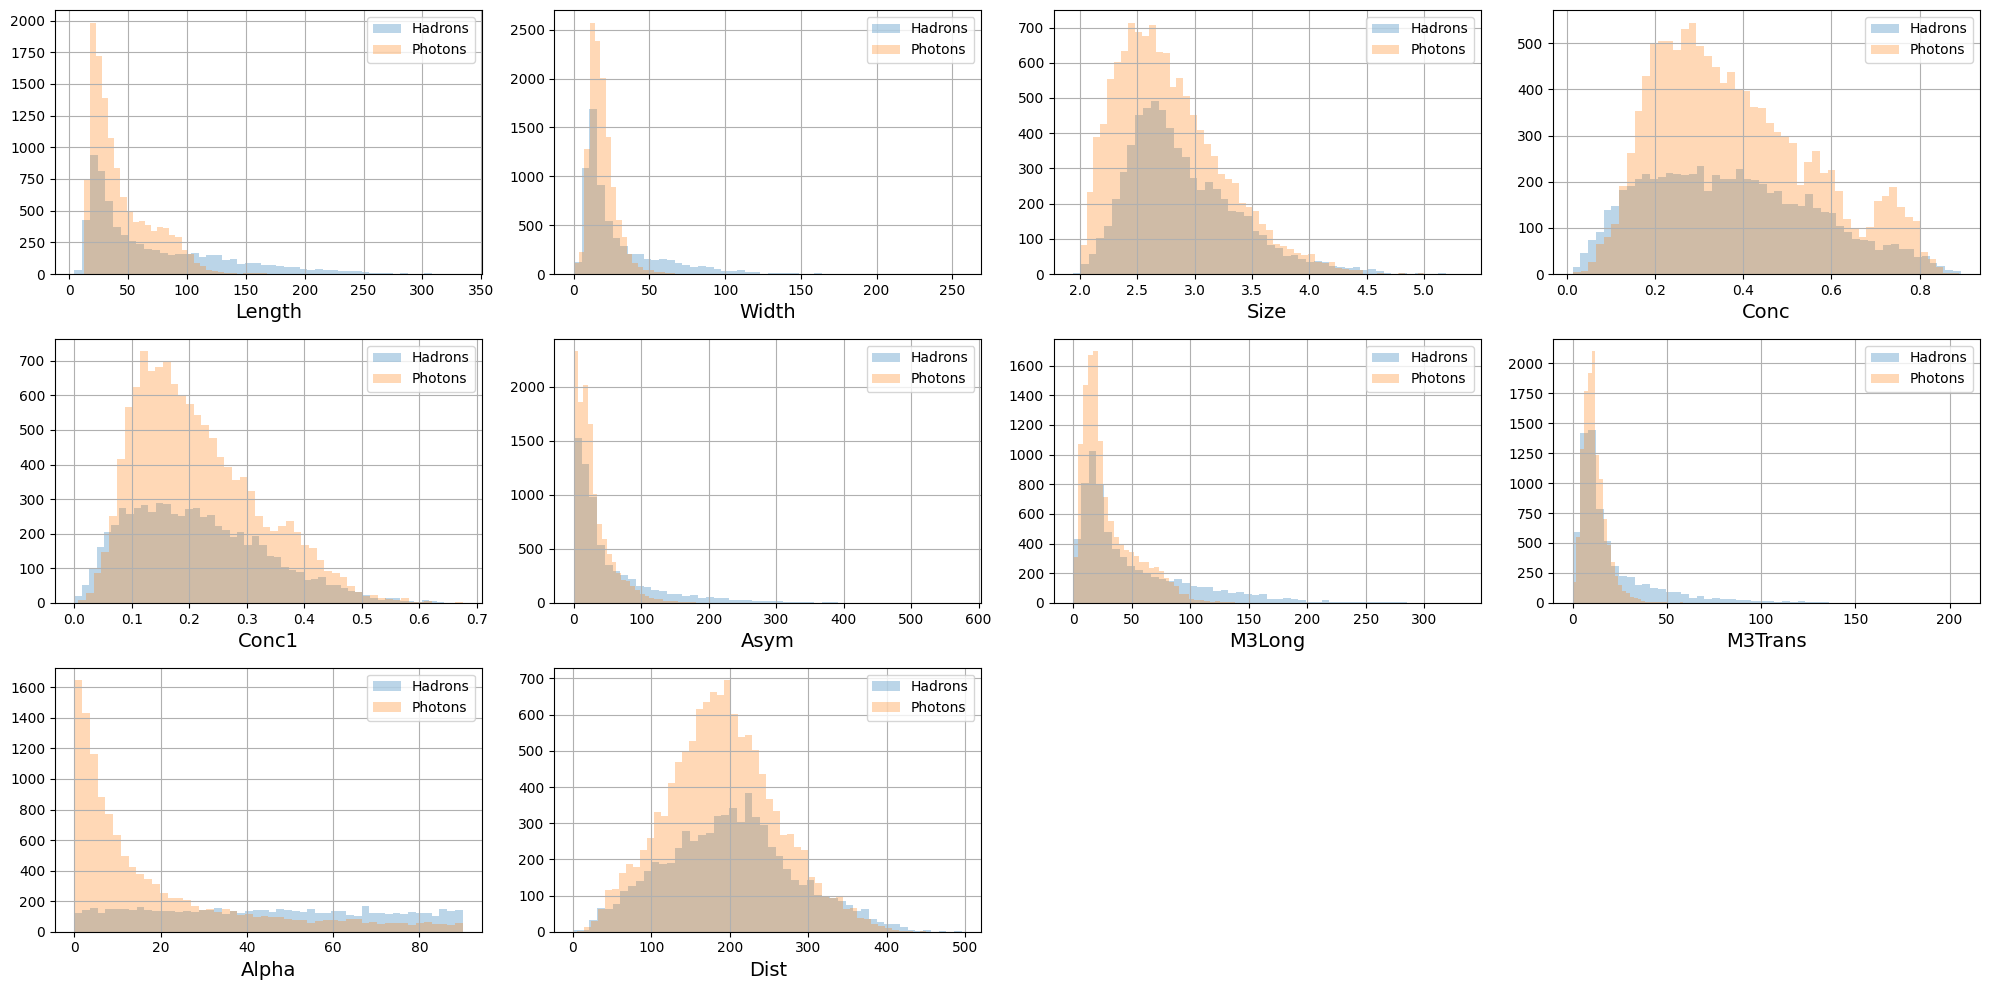

In [8]:
plot_hists(
    X[y[:, 0] == 0], X[y[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

# Предобработка данных

Из графика видим, что распределения для многих признаков имеют тяжелые хвосты. Это делает обучение генеративных моделей тяжелее. Поэтому нужно как-то преобразовать данные, чтобы убрать эти тяжелые хвосты.

# Обучающая и тестовая выборки

In [9]:
from sklearn.model_selection import train_test_split

# train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify = y, test_size=0.5, shuffle = True, random_state = 11
)

## Задание 1 (0 баллов)

Проиллюстрируйте распределение y внутри train и test выборки.

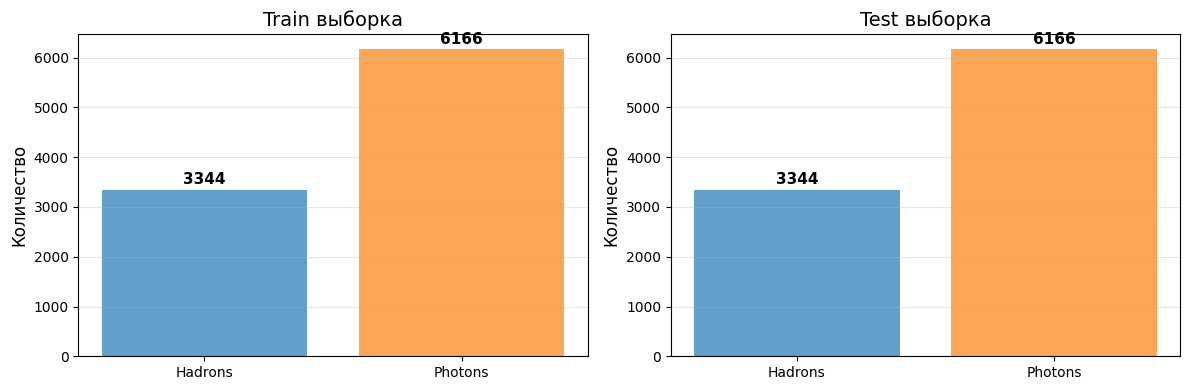

In [10]:
# your code below
# y содержит метки классов: 0 = Hadrons (адроны), 1 = Photons (фотоны)

# Подсчитываем количество каждого класса
train_counts = np.unique(y_train, return_counts=True)
test_counts = np.unique(y_test, return_counts=True)

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Train
axes[0].bar(['Hadrons', 'Photons'], train_counts[1], color=['C0', 'C1'], alpha=0.7)
axes[0].set_ylabel('Количество', size=12)
axes[0].set_title('Train выборка', size=14)
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(train_counts[1]):
    axes[0].text(i, v + 50, str(v), ha='center', va='bottom', fontsize=11, fontweight='bold')

# Test
axes[1].bar(['Hadrons', 'Photons'], test_counts[1], color=['C0', 'C1'], alpha=0.7)
axes[1].set_ylabel('Количество', size=12)
axes[1].set_title('Test выборка', size=14)
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(test_counts[1]):
    axes[1].text(i, v + 50, str(v), ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

## Задание 2 (0 баллов)

Используя функцию `sklearn.preprocessing.QuantileTransformer` трансформируйте входные данные `X_train` и `X_test`. Это преобразование делает так, чтобы распределение каждого параметра было нормальным. Описание функции доступно по [ссылке](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html). Используйте значение параметра `output_distribution='normal'`.

In [11]:
### YOUR CODE IS HERE ######
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution='normal')

X_train = qt.fit_transform(X_train)
X_test = qt.transform(X_test)
### THE END OF YOUR CODE ###

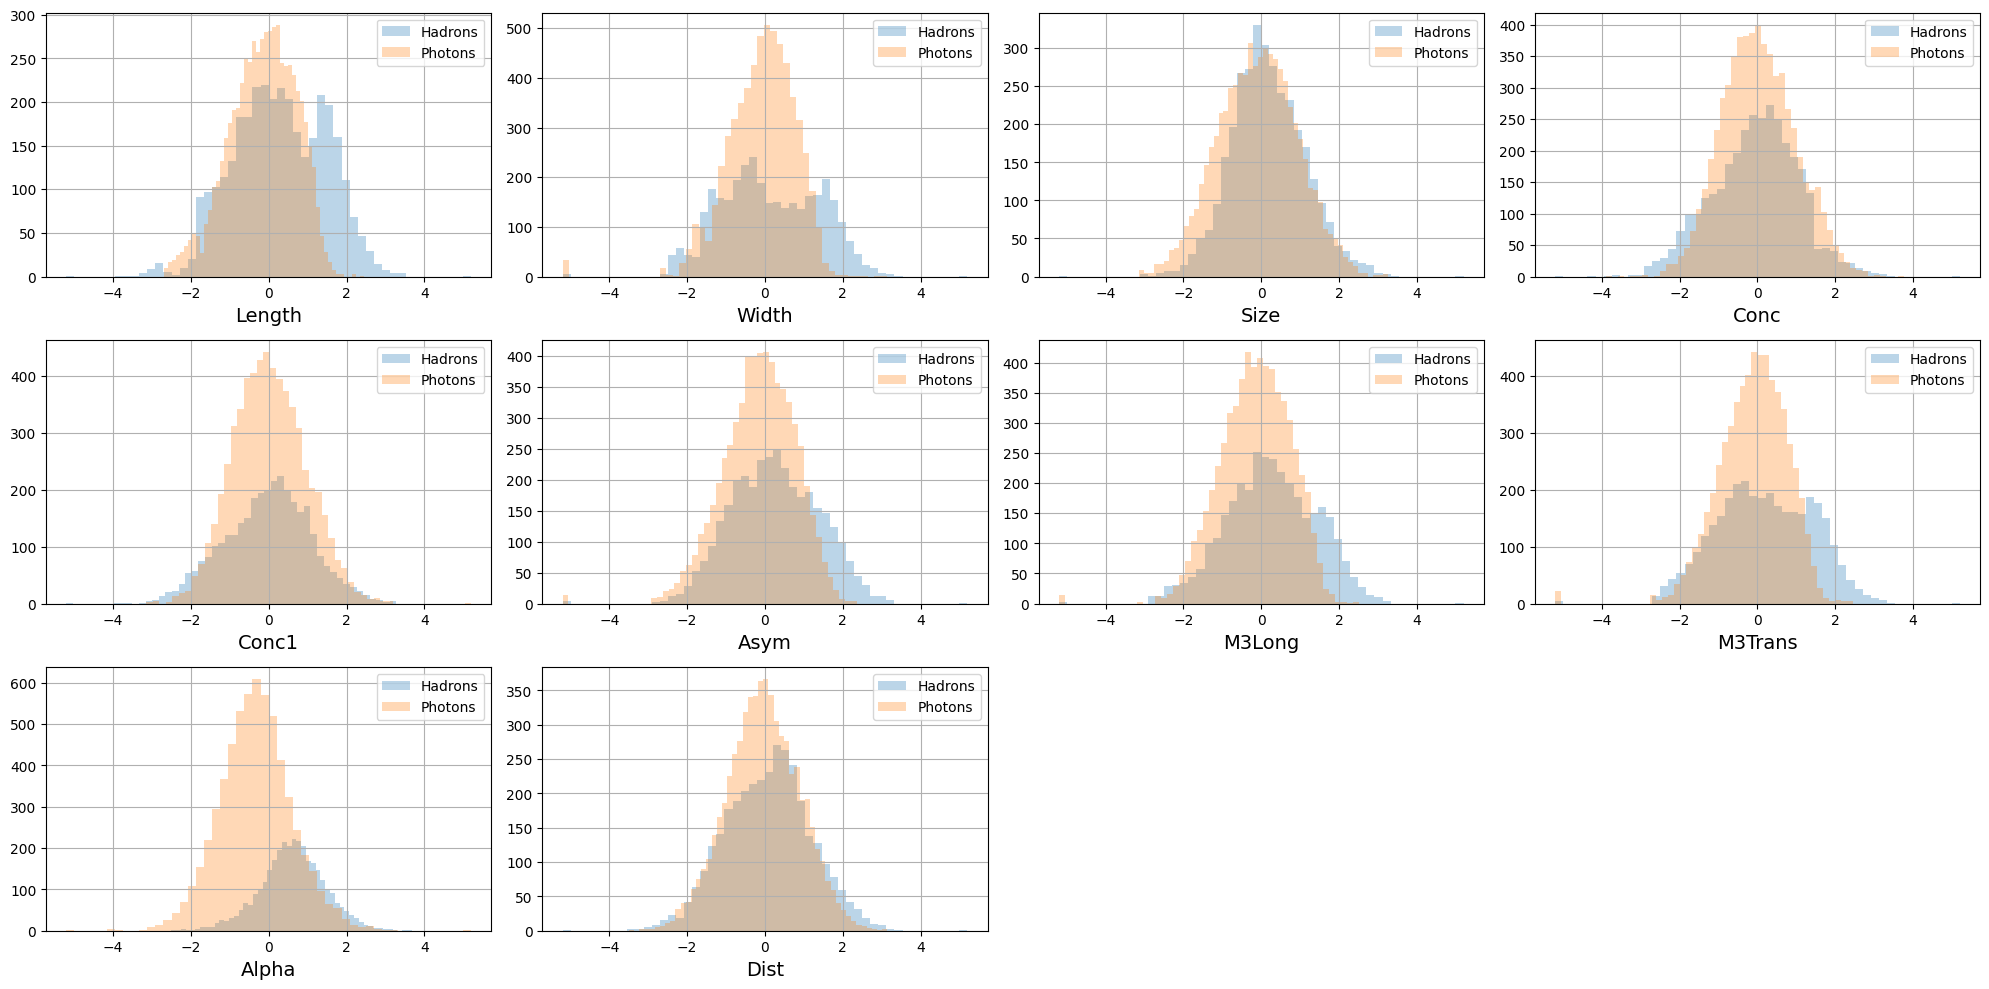

In [12]:
plot_hists(
    X_train[y_train[:, 0] == 0],
    X_train[y_train[:, 0] == 1],
    names,
    label1="Hadrons",
    label2="Photons",
    bins=50,
)

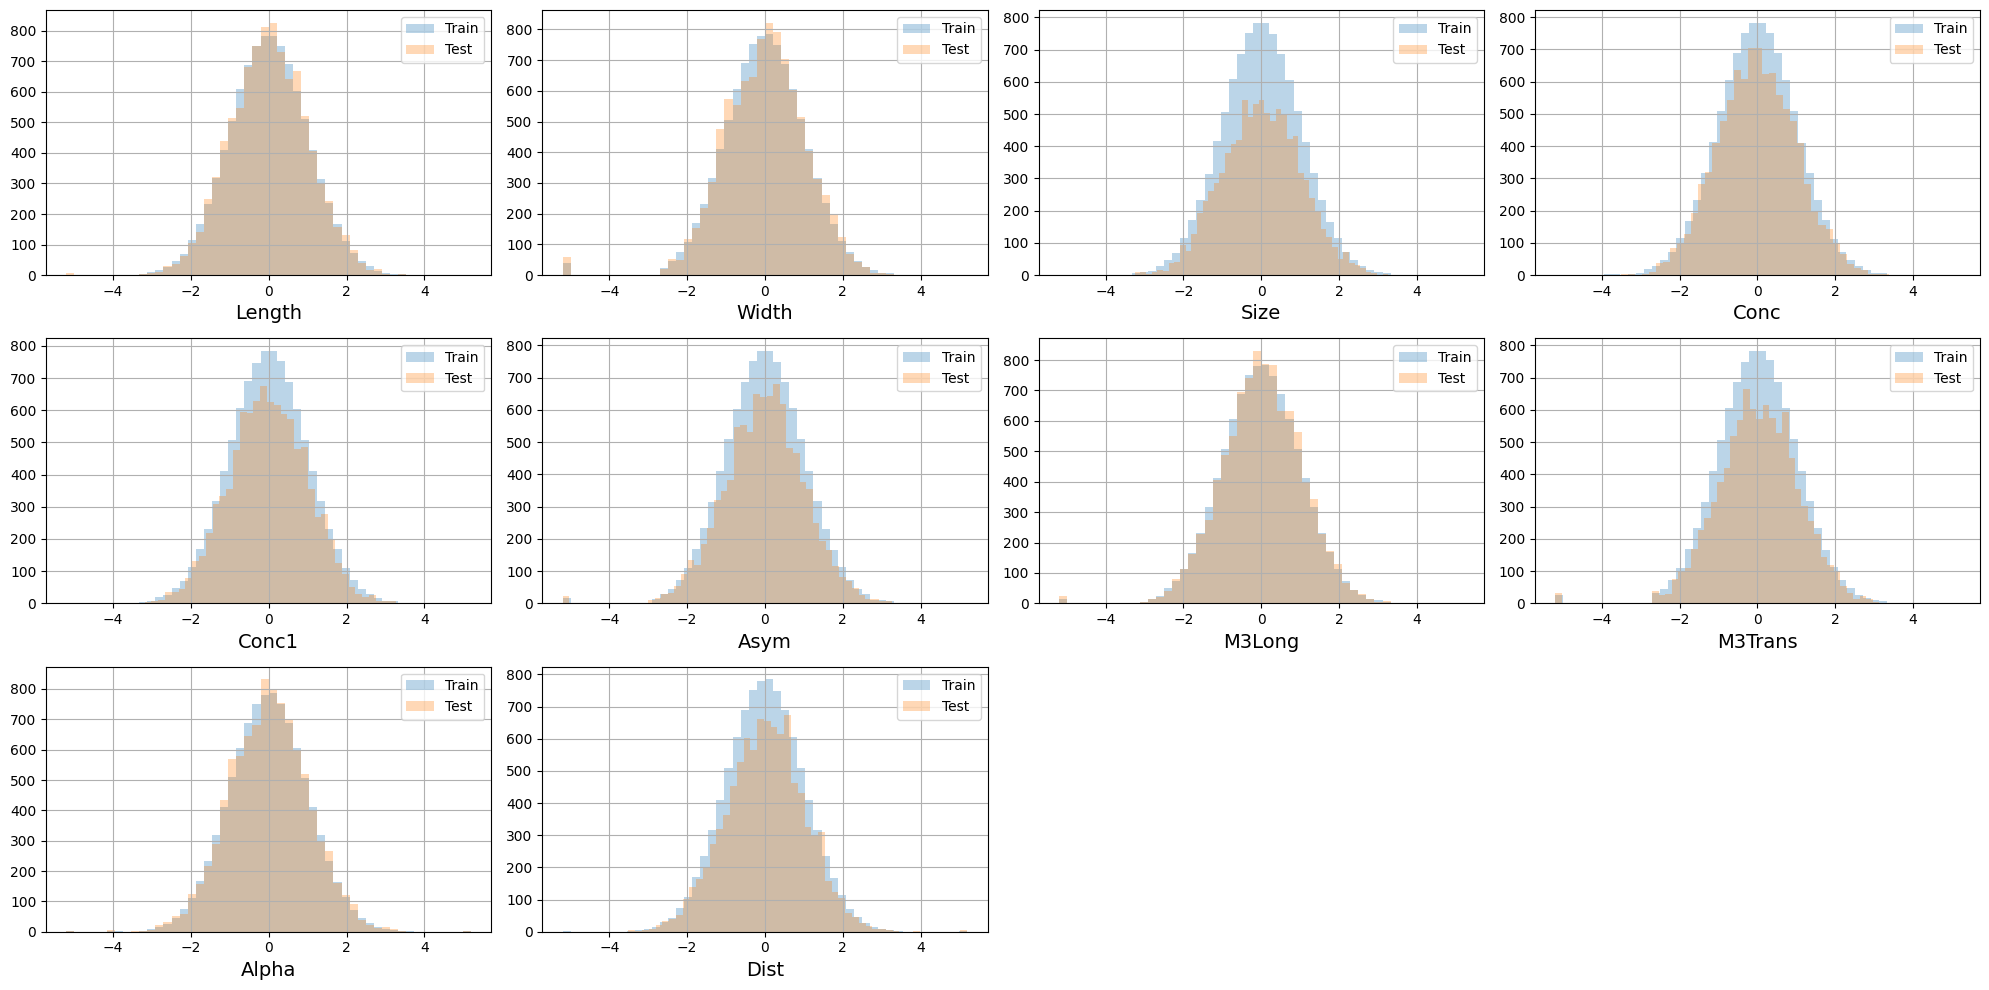

In [13]:
plot_hists(X_train, X_test, names, label1="Train", label2="Test", bins=50)

# Диффузионные модели (4 балла)

Проведем, по большому счету, такой же эксперимент, как в ДЗ-2, с диффузионной моделью.

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Задание 3 (0.5 балла)

Реализуйте фукнцию из семинара для зашумления данных, адаптировав ее под наш тип данных.

In [15]:
def corrupt(x, amount):
    ### YOUR CODE IS HERE ######
    noise = torch.randn_like(x)
    amount = amount.view(-1, 1)
    return x * (1 - amount) + noise * amount
    ### THE END OF YOUR CODE ###

Добавим sсheduler, он пригодится вам при обучении модели.

*Советуем вниматиельно почитать доку по шедулеру.*

In [16]:
from diffusers import DDPMScheduler

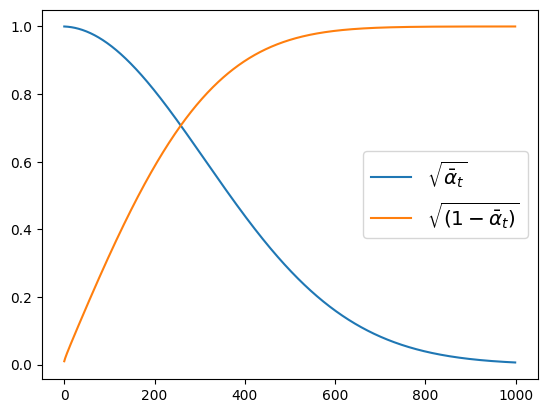

In [17]:
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    clip_sample=True,  # Включаем обрезание значений для стабильности
    clip_sample_range=5.5,  # Диапазон обрезания [-5.5, 5.5] чтобы покрыть данные
    prediction_type="epsilon"  # Предсказываем шум (epsilon), а не исходное изображение
)
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large")

## Задание 4 (0.5 балла)

Реализуйте нейронную сеть. В качетсве архитектуры можете взять модель генератора. В процессе экспериментов попробуйте изменять архитектуру модели для улучшения качества сгенерированных объектов (Кстати, как вы будете качество измерять?).

- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [18]:
class DiffusionGenerator(nn.Module):
    def __init__(self, data_dim, n_hidden=100, time_embed_dim=100):
        super(DiffusionGenerator, self).__init__()

        ### YOUR CODE IS HERE ######
        self.data_dim = data_dim
        self.n_hidden = n_hidden
        self.time_embed_dim = time_embed_dim

        # Embedding для временного шага
        self.time_embed = nn.Sequential(
            nn.Linear(1, time_embed_dim),
            nn.ReLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )

        # Полносвязные слои
        self.fc1 = nn.Linear(data_dim + 1 + time_embed_dim, n_hidden)  # data + condition + time_embed
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.fc_out = nn.Linear(n_hidden, data_dim)  # шум той же размерности, что и данные
        
        # ВАЖНО: Заменил BatchNorm на LayerNorm для избежания смещения при генерации.
        # BatchNorm собирает статистику по всем timesteps, а они при обучении рандомные,
        # что создает сдвиг распределения при inference
        self.ln1 = nn.LayerNorm(n_hidden)
        self.ln2 = nn.LayerNorm(n_hidden)


    def forward(self, x, t, y):
        # x: зашумленные данные [batch_size, data_dim]
        # t: временной шаг [batch_size, 1] или [batch_size]
        # y: условие [batch_size, 1]

        batch_size = x.shape[0]
        
        # Преобразуем t в embedding
        # Сначала преобразуем t в тензор, если это не тензор
        if not isinstance(t, torch.Tensor):
            t = torch.tensor(t, device=x.device)
        if t.dim() == 0:  # скаляр
            t = t.unsqueeze(0).repeat(batch_size)  # [batch_size]
        if t.dim() == 1:
            t = t.unsqueeze(-1).float()  # [batch_size, 1]
        
        # ВАЖНО: Нормализуем timestep к диапазону [0, 1] для стабильности
        t = t / 1000.0  # num_train_timesteps = 1000
        
        t_embed = self.time_embed(t)  # [batch_size, time_embed_dim]

        # Конкатенируем: зашумленные данные + условие + time embedding
        inputs = torch.cat([x, y, t_embed], dim=1)

        # Пропускаем через сеть
        h = F.relu(self.ln1(self.fc1(inputs)))
        h = F.relu(self.ln2(self.fc2(h)))
        return self.fc_out(h)

## Задание 5 (0.5 балла)

Напишите функцию для генерации нового объекта с помощью обученной модели.

In [19]:
def generate_with_diffusion(model, y, sheduler):
    ### YOUR CODE IS HERE ######

    # ВАЖНО: удалил параметр latent_dim, который попал сюда из GAN
    # В диффузионных моделях данные генерируются из шума того же размера

    # Переводим y на нужное устройство
    device = next(model.parameters()).device
    y = torch.tensor(y, dtype=torch.float, device=device)
    
    # Размер батча
    batch_size = y.shape[0]
    
    # Начинаем с чистого шума размера [batch_size, data_dim]
    x = torch.randn(batch_size, model.data_dim, device=device)
    
    model.eval()
    with torch.no_grad():
        # Обратная диффузия
        for t in sheduler.timesteps:
            t_tensor = t.to(device=device, dtype=torch.long)
            predicted_noise = model.forward(x, t_tensor, y)

            # Обновляем через шедулер
            x = sheduler.step(predicted_noise, t, x).prev_sample
    
    # на выход - numpy array
    X_fake = x.detach().cpu().numpy()
    ### THE END OF YOUR CODE ###
    return X_fake  # numpy

## Задание 6 (2 балла)

Напишите класс обучения диффузионной модели и обучите модель, после чего опишите полученные результаты. В качестве подсказки - опирайтесь на семинар по диффузионным моделям. Вы можете изменять некоторые части кода для вашего удобства, но оставляйте в таком случаи комментарии, пожалуйста.

In [20]:
# Функция `other_agent_score`, которая упомянута в `readme.md` и в цикле обучения модели
def other_agent_score(X_real, X_fake, random_state=42, silent=False):
    """
    Оценивает качество генерации путем обучения классификаторов отличать реальные данные от фейковых.
    
    Args:
        X_real: numpy array с реальными объектами
        X_fake: numpy array со сгенерированными объектами
        random_state: random state для воспроизводимости
    
    Returns:
        dict: словарь с accuracy_score для линейной регрессии и градиентного бустинга
    """
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import GradientBoostingClassifier
    from sklearn.metrics import accuracy_score, roc_auc_score
    
    # Создаем метки: 1 для реальных, 0 для фейковых
    y_real = np.ones(X_real.shape[0])
    y_fake = np.zeros(X_fake.shape[0])
    
    # Объединяем реальные и фейковые данные
    X_combined = np.vstack([X_real, X_fake])
    y_combined = np.concatenate([y_real, y_fake])
    
    # Разделяем на train/test с учетом баланса классов (stratify=y_combined)
    # Соотношение train:test = 3:1 (75% train, 25% test)
    X_train, X_test, y_train, y_test = train_test_split(
        X_combined, y_combined, 
        test_size=0.25,  # 25% для test (3:1 соотношение)
        stratify=y_combined,  # сохраняем баланс классов
        random_state=random_state
    )
    
    # Обучаем линейную регрессию (LogisticRegression для классификации)
    lr_model = LogisticRegression(random_state=random_state, max_iter=1000)
    lr_model.fit(X_train, y_train)
    lr_pred = lr_model.predict(X_test)
    lr_accuracy = accuracy_score(y_test, lr_pred)
    lr_auc = roc_auc_score(y_test, lr_pred)
    
    # Обучаем градиентный бустинг
    gb_model = GradientBoostingClassifier(random_state=random_state)
    gb_model.fit(X_train, y_train)
    gb_pred = gb_model.predict(X_test)
    gb_accuracy = accuracy_score(y_test, gb_pred)
    gb_auc = roc_auc_score(y_test, gb_pred)
    
    # Выводим результаты
    if not silent:
        print(f"Other Agent Score: LogReg={lr_accuracy:.4f}, LogReg AUC={lr_auc:.4f}, GB={gb_accuracy:.4f}, GB AUC={gb_auc:.4f}")
    
    return {
        'linear_regression_accuracy': lr_accuracy,
        'linear_regression_auc': lr_auc,
        'gradient_boosting_accuracy': gb_accuracy,
        'gradient_boosting_auc': gb_auc
    }


> При написании цикла обучения вдохновлялся этим примером
https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/training_example.ipynb

In [21]:
class DiffusionFitter(object):
    def __init__(
        self,
        model,
        batch_size = 32,
        n_epochs = 10,
        lr = 0.0001,
        # latent_dim = 10,      # осталось от GAN
        # n_critic=5,           # осталось от GAN 
        noise_scheduler=None,   # добавил для передачи в функцию generate_with_diffusion
    ):

        self.model = model
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        # self.latent_dim = latent_dim
        self.lr = lr
        # self.n_critic = n_critic
        self.noise_scheduler = noise_scheduler

        self.opt_gen = torch.optim.RMSprop(self.model.parameters(), lr=self.lr)

        self.model.to(DEVICE)

    def fit(self, X, y):

        # Добавил сохранение оригинальных данных для оценки качества
        self.X_train = X
        self.y_train = y

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.model.train(True)

        self.loss_history = []

        # Fit
        for epoch in range(self.n_epochs):
            loss_epoch = 0
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

                ### YOUR CODE IS HERE #####
                bs = real_batch.shape[0]  # batch size (на последнем может отличаться от batch_size)

                # Переводим батч на устройство
                real_batch = real_batch.to(DEVICE)
                cond_batch = cond_batch.to(DEVICE)

                # Генерируем случайный шум для батча
                noise = torch.randn_like(real_batch).to(DEVICE)

                # Берем случайное число шагов из [0, num_train_timesteps) для каждого примера в батче
                timesteps = torch.randint(0, self.noise_scheduler.config.num_train_timesteps, (bs,), device=DEVICE).long()

                # Добавляем шум к реальным данным - прямая диффузия
                noisy_batch = self.noise_scheduler.add_noise(real_batch, noise, timesteps)

                # Предсказываем шум - обратная диффузия
                predicted_noise = self.model(noisy_batch, timesteps, cond_batch)

                # Вычисляем loss
                loss = F.mse_loss(predicted_noise, noise)

                # Обратное распространение
                self.opt_gen.zero_grad()
                loss.backward()
                self.opt_gen.step()

                loss_epoch += loss.item()
                ### THE END OF YOUR CODE ###

            # caiculate and store loss after an epoch

            self.loss_history.append(loss_epoch)

            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов
            # И запустите работу фукнции other_agent_score

            ### YOUR CODE IS HERE ######
            # Сомневаюсь, что это нужно делать на каждой эпохе, поэтому пусть будет так
            if epoch % 100 == 0:
                # Случайно выбираем 1000 объектов из X_train
                indices = np.random.choice(len(self.X_train), size=1000, replace=True)
                X_real_sample = self.X_train[indices]
                y_sample = self.y_train[indices]
                
                # Генерируем 1000 объектов с помощью модели
                X_fake_sample = generate_with_diffusion(
                    self.model, y_sample, self.noise_scheduler
                )
                
                # Оцениваем качество генерации
                oas = other_agent_score(X_real_sample, X_fake_sample, random_state=42, silent=True)
                print(f"Epoch {epoch}: Loss = {loss_epoch:.4f}, LogReg AUC={oas['linear_regression_auc']:.4f}, GB AUC={oas['gradient_boosting_auc']:.4f}")
            ### THE END OF YOUR CODE ###
        # Turn off training
        self.model.train(False)

In [22]:
%%time
# latent_dim = 20
# model = DiffusionGenerator(data_dim=X_train.shape[1], n_hidden=200, time_embed_dim=200)
model = DiffusionGenerator(data_dim=X_train.shape[1])

diffusionFitter = DiffusionFitter(
    model,
    batch_size=512,
    n_epochs=201,
    # latent_dim=latent_dim,
    lr=0.00005,
    noise_scheduler=noise_scheduler,
)
diffusionFitter.fit(X_train, y_train)

Epoch 0: Loss = 17.7133, LogReg AUC=0.7740, GB AUC=0.9980
Epoch 100: Loss = 4.2452, LogReg AUC=0.5780, GB AUC=0.6700
Epoch 200: Loss = 3.9871, LogReg AUC=0.5560, GB AUC=0.5940
CPU times: user 26.9 s, sys: 319 ms, total: 27.2 s
Wall time: 23.8 s


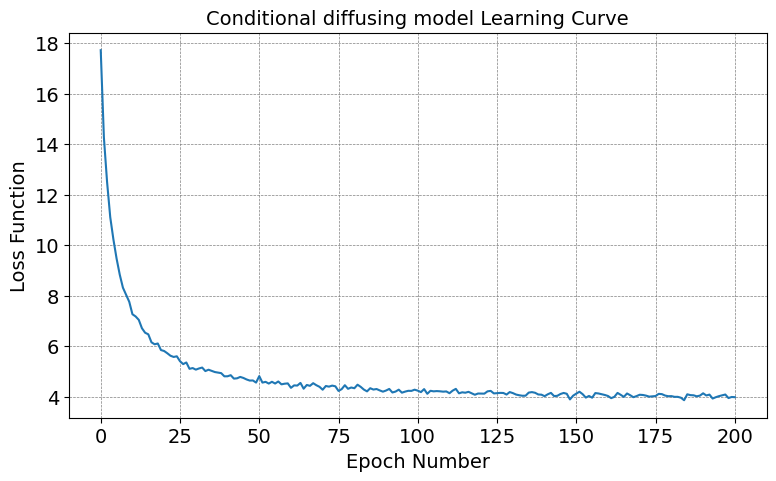

In [23]:
# diffusion learning curve
plt.figure(figsize=(9, 5))
plt.plot(diffusionFitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional diffusing model Learning Curve", size=14)
# plt.grid( b=1, linestyle="--", linewidth=0.5, color="0.5")
plt.grid(linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 7 (0.5 балла)
По аналогии с прошлым экспериментом (из ДЗ-2) с GAN моделью сгенерируйте выборку фейковых объектов, равную размеру тестовой выборки, и обучите градиентный бустинг. Обучите модель отличать реальные объекты от фейковых, после чего расчитайте метрики ROC-AUC и accuracy score. Какие получились результаты? Как вы их оцениваете? А в сравнении с сWGAN моделью?

> В ДЗ-2 делали немного по-другому - использовали вместе и `X_train`, и `X_test`.  
> Сделаю и тут аналогично, чтобы сравнение с GAN было более корректным.

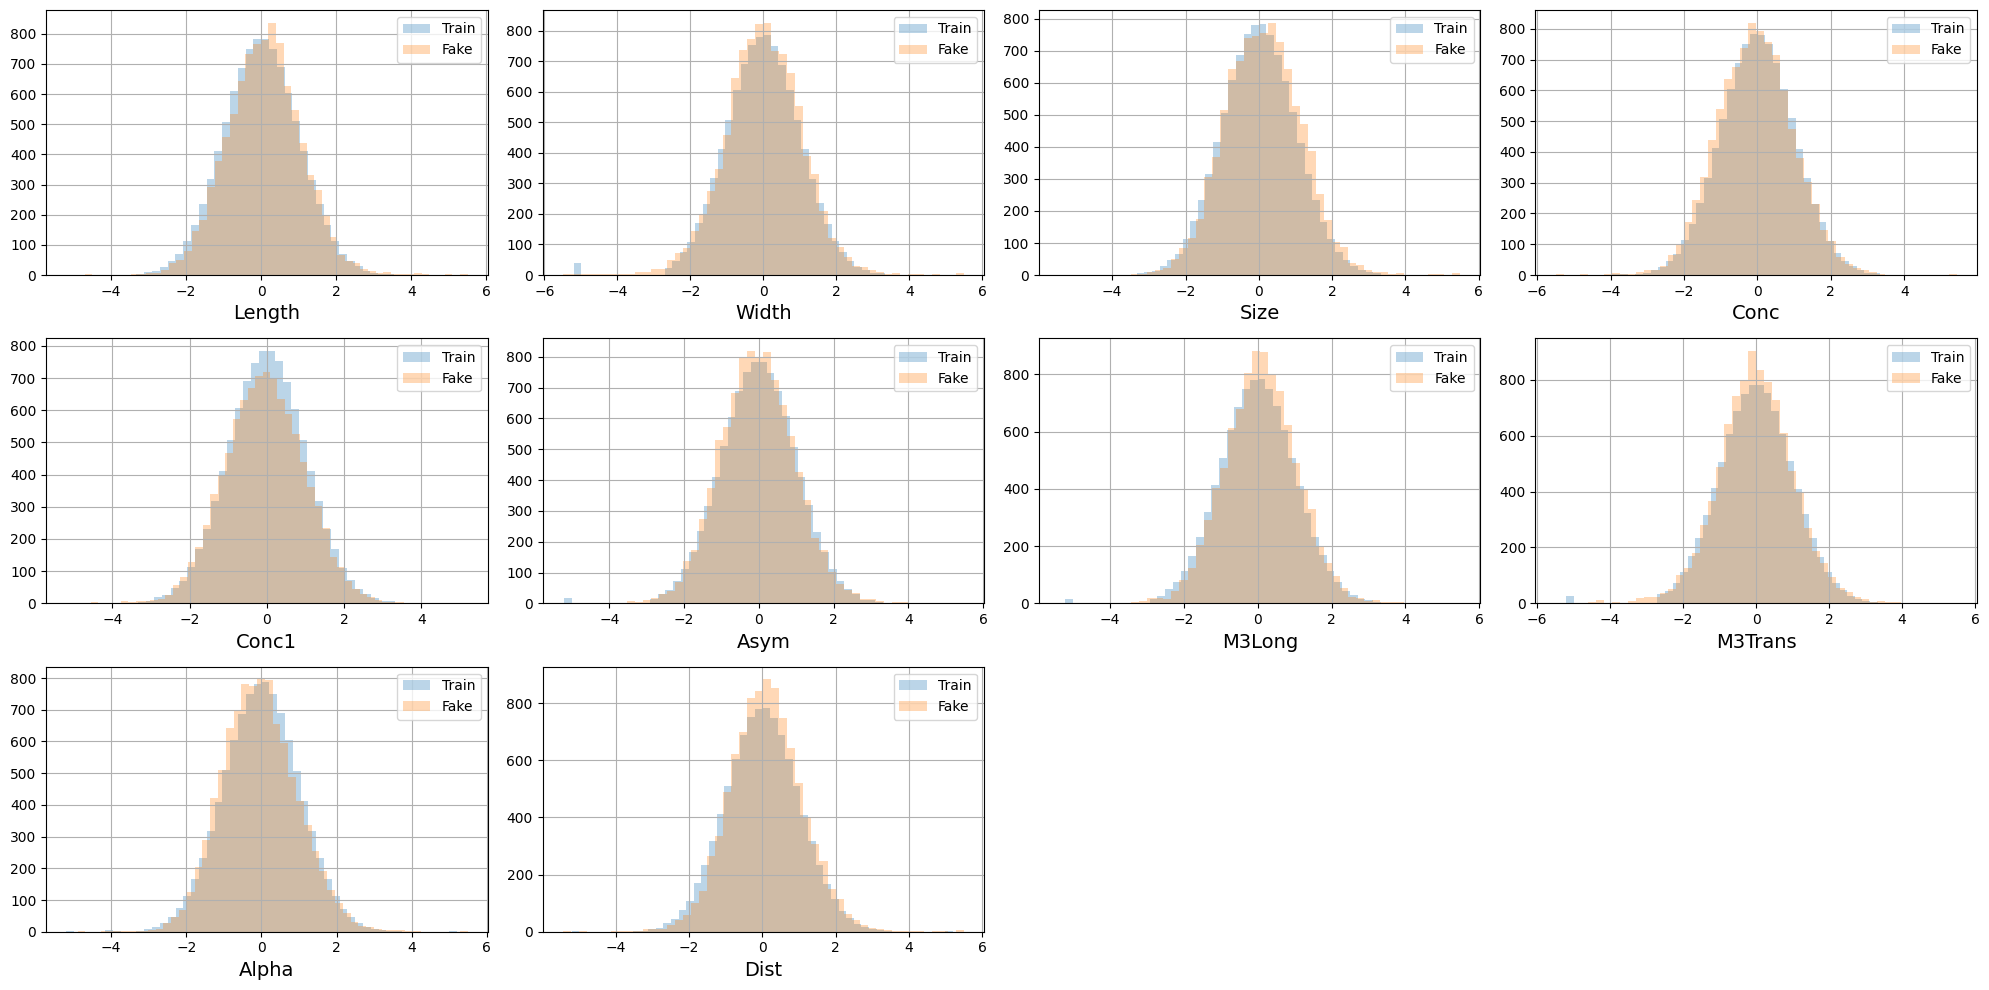

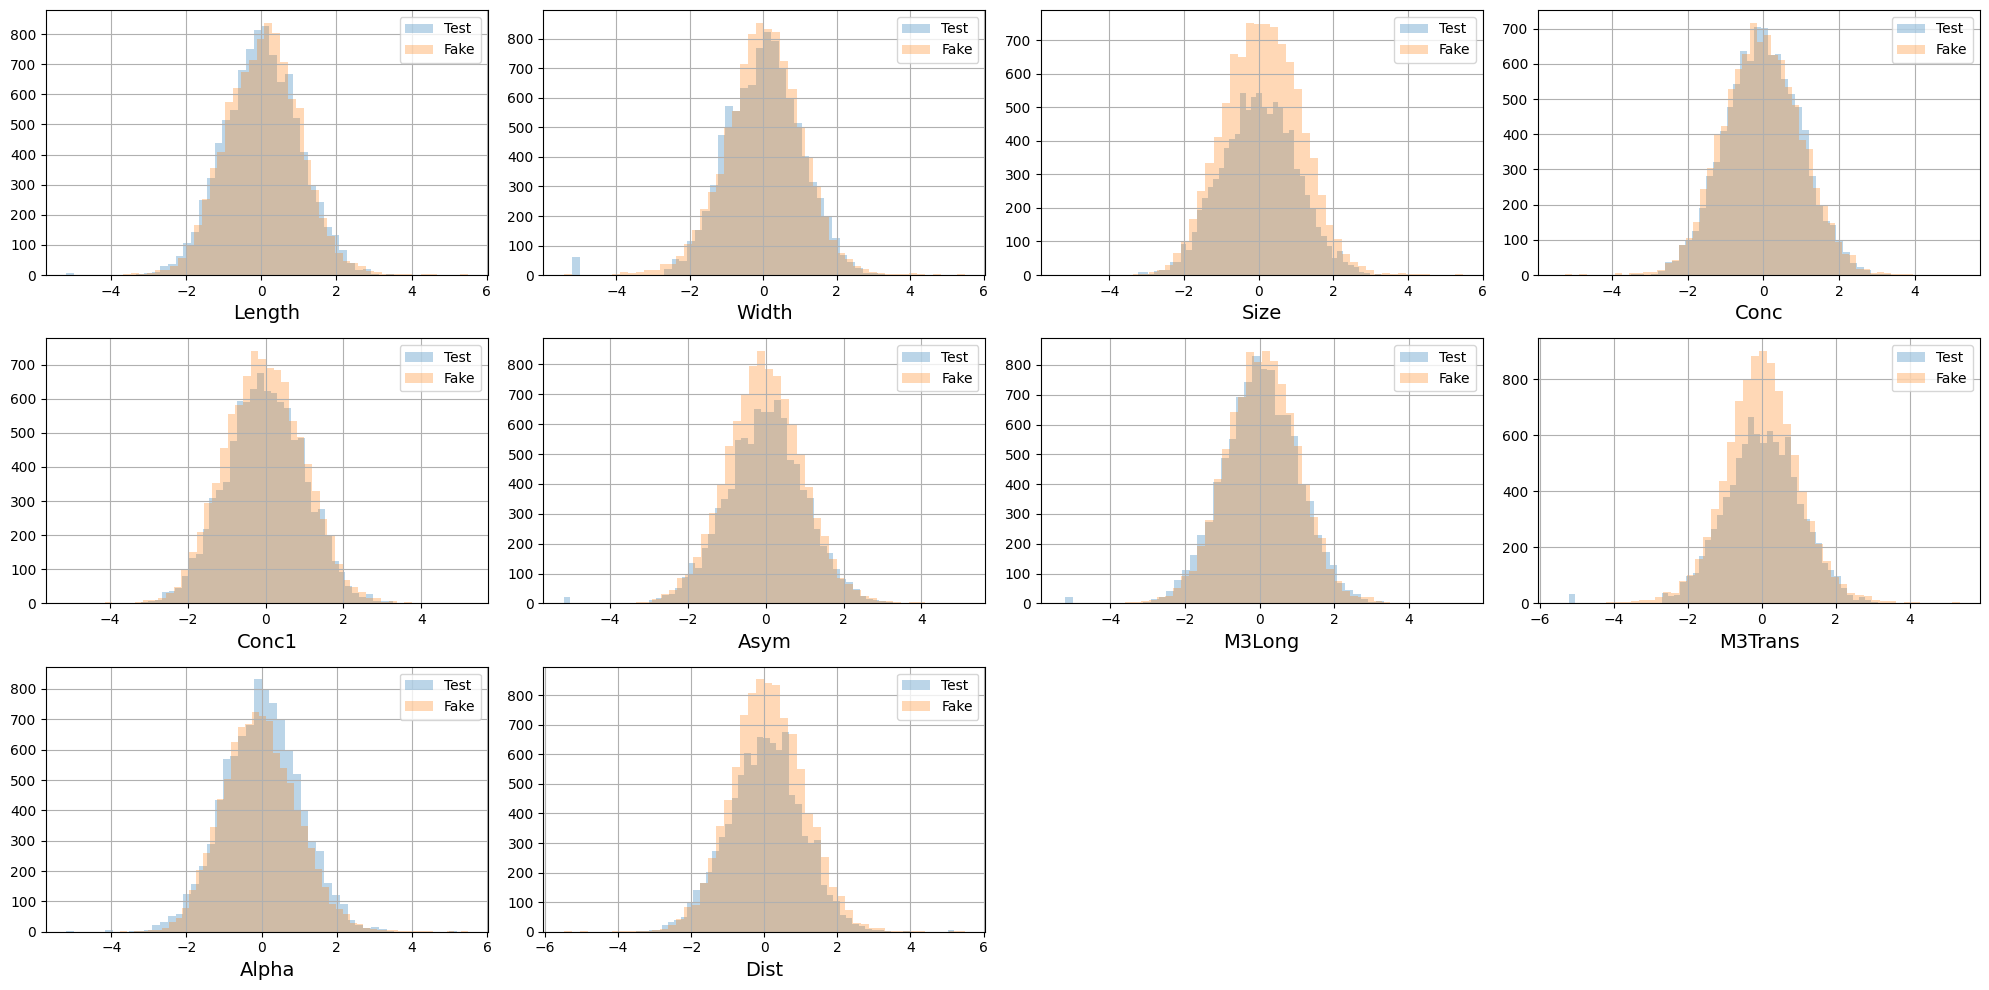

In [24]:
X_fake_train = generate_with_diffusion(diffusionFitter.model, y_train, noise_scheduler)
plot_hists(X_train, X_fake_train, names, label1="Train", label2="Fake", bins=50)

X_fake_test = generate_with_diffusion(diffusionFitter.model, y_test, noise_scheduler)
plot_hists(X_test, X_fake_test, names, label1="Test", label2="Fake", bins=50)

Задам в виде функции аналогичный ДЗ-2 способ вычисления `ROC AUC`

In [25]:
def ROC_AUC_like_HW2(X_train, X_fake_train, X_test, X_fake_test):
    from sklearn.ensemble import GradientBoostingClassifier
    from sklearn.metrics import roc_auc_score
    
    # собираем реальный и фейковые матрицы в одну
    XX_train = np.concatenate((X_fake_train, X_train), axis=0)
    XX_test = np.concatenate((X_fake_test, X_test), axis=0)

    yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
    yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

    # обучаем классификатор
    clf = GradientBoostingClassifier()
    clf.fit(XX_train, yy_train)

    # получаем прогнозы
    yy_test_proba = clf.predict_proba(XX_test)[:, 1]

    auc = roc_auc_score(yy_test, yy_test_proba)
    print("ROC AUC = ", auc)

In [26]:
ROC_AUC_like_HW2(X_train, X_fake_train, X_test, X_fake_test)

ROC AUC =  0.6975726972880392


### Вывод 1.
Диффузионная модель при схожих параметрах (n_hidden=100, оптимизатор) показала немного более лучший результат.

| Модель      | ROC AUC |
|-------------|---------|
| Диффузия    |  0.70   |
| GAN (ДЗ-2)  |  0.74   |

# Потоки (4 балла)

## Задание 8 (1.5 балла)

Диффузия показала себя как достойный конкурент GAN модели. Так как данных не много, обучали не долго, задача не сложная - отличия от GAN не так заметны, но все равно достойные.

Для Diffusion получили ROC AUC около 0.73 (меньше лучше). Попробуем обучить RealNVP для решения этой задачи.

**Дополните базовый класс для нормализационного необходимым.**

<center><img src="img/mem1.jpg" width="500"></center>

<center><img src="img/mem2.jpg" width="500"></center>

In [ ]:
trainloader = torch.utils.data.DataLoader(X_train, batch_size=64, shuffle=True)

In [ ]:
# Main class for NormFlow
class NormalizingFlow(nn.Module):

    def __init__(self, layers, prior):
        super(NormalizingFlow, self).__init__()

        # your code below

    def log_prob(self, x):
        log_likelihood = None

        for layer in self.layers:
            x, change = layer.f(x)
            if log_likelihood is not None:
                log_likelihood = # your code here
            else:
                log_likelihood = # your code here

        log_likelihood = # your code here

        return log_likelihood.mean()

    def sample(self, num_samples):
        x = self.prior.sample((num_samples, ))

        for layer in self.layers[::-1]:
            x = layer.g(x)

        return x

## Задание 9 (2 балла)

Реализуйте нейронную сеть RealNVP. Возьмите для прямого и обратного преобразования нейронную сеть (функцию) со следующими параметрами:

- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Выходной слой.

In [ ]:
import torch.nn as nn

class RealNVP(nn.Module):
    def __init__(self, var_size, mask, hidden=100):
        super(RealNVP, self).__init__()
        self.mask = mask  # вам это может не понадобиться. Восприниматйте как подсказку
        self.var_size = var_size

        self.nn_t = # your code here
        self.nn_s = # your code here

    def f(self, x):
        t = # your code here
        s = # your code here

        new_x = # your code here

        log_det = # your code here
        return new_x, log_det

    def g(self, x):
        t = # your code here
        s = # your code here

        new_x = # your code here
        return new_x

In [ ]:
def train_nf(tr_dataloader, nf, opt, num_epochs):
    nf.train()
    loss_trace = []

    iter_i = 0

    for epoch_i in range(num_epochs):
        print(f'Epoch {epoch_i + 1}')
        for batch in tr_dataloader:

            x = batch.float()

            opt.zero_grad()

            loss = # your code here
            loss.backward()

            opt.step()

            loss_trace.append((iter_i, loss.item()))

            iter_i += 1

In [ ]:
prior = torch.distributions.MultivariateNormal(torch.zeros(10), torch.eye(10))

layers = []
for i in range(4):
    layers.append(RealNVP(var_size=10, mask=((torch.arange(10) + i) % 2)))

nf = NormalizingFlow(layers=layers,
                    prior=prior)

opt = torch.optim.Adam(nf.parameters(), lr=1e-3)

In [ ]:
train_nf(trainloader, nf, opt, num_epochs=10)

## Задание 10 (0.5 балла)

По аналогии с прошлым экспериментом с диффузией сгенерируйте выборку фейковых объектов, равную размеру тестовой выборки, и обучите градиентный бустинг. Обучите модель отличать реальные объекты от фейковых, после чего расчитайте метрики ROC-AUC и accuracy score. Какие получились результаты? Как вы их оцениваете? А в сравнении с остальными моделями?

# Улучшения (1+ балл)

Попробуйте настроить параметры обучения какой-нибудь модели или еще как-нибудь их улучшить, чтобы получить как можно меньший ROC AUC. Что получилось? Какая модель лучше?

Ставим 0.1 балл за каждую сотую скора сверх (сниз) ROC-AUC=0.65 невключительно. Т.е. за 0.65 получаете 0, за 0.649 -- 0.1, 0.639 -- 0.2, 0.609 -- 0.5, 0.559 -- 1

In [ ]:
# your code here


# (*) Аналитика (1 балл)

***Убедительно* подвтердите или опровергните гипотезу "Синтетические данные НЕ помогают лучше классифицировать частицы из исходного датасета."**

Здесь от вас ожидается что-то в духе аналитической записки. Приветствуются графики и прочие "умные вещи". На максимальный балл это весьма объемное задание.